In [1]:
import pandas as pd
import sqlite3
from src.utils.os_helper import get_project_root
import os

In [2]:
repo = get_project_root()

CACHE_DIR = repo / "cache" / "data" / "awesome_cgm" / "aleppo"
data_tables = CACHE_DIR / "raw" / "Data Tables"
db_path = CACHE_DIR / "awesome_cgm.db"

# SQLite param cap (commonly 999). Keep a margin.
SQLITE_MAX_VARS = 999
MARGIN = 10

In [ ]:
con = sqlite3.connect(db_path)
cur = con.cursor()
cur.execute("PRAGMA journal_mode=WAL;")
cur.execute("PRAGMA synchronous=OFF;")
cur.execute("PRAGMA temp_store=MEMORY;")

for f in sorted(data_tables.glob("*.txt")):
    table = f.stem
    print(f"Importing {f.name} -> {table}")

    # Stream in chunks to control memory and SQL variables
    first = True
    for df in pd.read_csv(f, sep="|", dtype=str, low_memory=False, chunksize=50_000):
        ncols = len(df.columns)
        # rows per insert so (rows * cols) <= SQLITE_MAX_VARS - MARGIN
        safe_rows = max(1, (SQLITE_MAX_VARS - MARGIN) // max(1, ncols))

        # method=None avoids multi-row SQL text construction; Pandas will executemany
        df.to_sql(
            table,
            con,
            if_exists="replace" if first else "append",
            index=False,
            chunksize=safe_rows,
            method=None,
        )
        first = False


indexes = [
    # Bolus Indexes
    "CREATE INDEX idx_hdevicebolus_ptid ON HDeviceBolus(PtID);",
    "CREATE INDEX idx_hdevicebolus_parentid ON HDeviceBolus(ParentHDeviceUploadsID);",
    "CREATE INDEX idx_hdevicebolus_ptid_days ON HDeviceBolus(PtID, DeviceDtTmDaysFromEnroll);",
    "CREATE INDEX idx_hdevicebolus_normal ON HDeviceBolus(Normal) WHERE Normal IS NOT NULL;",
    "CREATE INDEX idx_hdevicebolus_order ON HDeviceBolus(PtID, DeviceDtTmDaysFromEnroll, DeviceTm);",
    # Uploads Indexes
    "CREATE INDEX idx_hdeviceuploads_recid ON HDeviceUploads(RecID);",
    "CREATE INDEX idx_hdeviceuploads_ptid ON HDeviceUploads(PtID);",
    "CREATE INDEX idx_hdeviceuploads_device ON HDeviceUploads(DeviceModel, DeviceType);",
    # CGM Indexes
    "CREATE INDEX idx_hdevicecgm_recid ON HDeviceCGM(RecID);",
    "CREATE INDEX idx_hdevicecgm_recordtype ON HDeviceCGM(RecordType);",
    "CREATE INDEX idx_hdevicecgm_ptid_days ON HDeviceCGM(PtID, DeviceDtTmDaysFromEnroll);",
    "CREATE INDEX idx_hdevicecgm_ptid_time ON HDeviceCGM(PtID, DeviceTm);",
    # Wizard Indexes
    "CREATE INDEX idx_hdevicewizard_recid ON HDeviceWizard(RecID);",
    "CREATE INDEX idx_hdevicewizard_ptid ON HDeviceWizard(PtID);",
    "CREATE INDEX idx_hdevicewizard_ptid_days ON HDeviceWizard(PtID, DeviceDtTmDaysFromEnroll);",
    "CREATE INDEX idx_hdevicewizard_ptid_time ON HDeviceWizard(PtID, DeviceTm);",
]

for i, index_sql in enumerate(indexes):
    try:
        cur.execute(index_sql)
        print(
            f"Created index {i+1}/{len(indexes)}: {index_sql.split('ON ')[1].split('(')[0]}"
        )
    except sqlite3.Error as e:
        print(f"Error creating index: {e}")

con.commit()
con.close()

Importing HAEDeviceProblems.txt -> HAEDeviceProblems
Importing HAdvEvent.txt -> HAdvEvent
Importing HComplUnblindCGM.txt -> HComplUnblindCGM
Importing HDeviceBGM.txt -> HDeviceBGM
Importing HDeviceBasal.txt -> HDeviceBasal
Importing HDeviceBolus.txt -> HDeviceBolus
Importing HDeviceCGM.txt -> HDeviceCGM
Importing HDeviceDtTmVer.txt -> HDeviceDtTmVer
Importing HDeviceEvents.txt -> HDeviceEvents
Importing HDeviceIssue.txt -> HDeviceIssue
Importing HDeviceUploads.txt -> HDeviceUploads
Importing HDeviceWizard.txt -> HDeviceWizard
Importing HFollowUp.txt -> HFollowUp
Importing HHypoEvent.txt -> HHypoEvent
Importing HInitialStudyCGM.txt -> HInitialStudyCGM
Importing HInsulin.txt -> HInsulin
Importing HLocalHbA1c.txt -> HLocalHbA1c
Importing HMedicalCondition.txt -> HMedicalCondition
Importing HMedication.txt -> HMedication
Importing HPostRandPtFinalStatus.txt -> HPostRandPtFinalStatus
Importing HPtRoster.txt -> HPtRoster
Importing HQuestDiabTech.txt -> HQuestDiabTech
Importing HQuestHypoFear

In [ ]:
def query_db(query: str):
    # Open the connection first
    con = sqlite3.connect(db_path)
    # cur = con.cursor()
    df = pd.read_sql_query(query, con)
    con.close()
    return df

### Data analysis


In [5]:
analysis_query = """
WITH
  params AS (
    SELECT '2020-01-01' AS base_date
  ),
  bolus AS (
    SELECT
      HDeviceBolus.PtID AS pid,
      datetime(
        julianday((SELECT base_date FROM params))
        + CAST(HDeviceBolus.DeviceDtTmDaysFromEnroll AS INTEGER)
        + (julianday(HDeviceBolus.DeviceTm) - julianday('00:00:00'))
      ) AS dt
    FROM HDeviceBolus
    WHERE HDeviceBolus.Normal IS NOT NULL
  ),
  wizard AS (
    SELECT
      HDeviceWizard.PtID AS pid,
      datetime(
        julianday((SELECT base_date FROM params))
        + CAST(HDeviceWizard.DeviceDtTmDaysFromEnroll AS INTEGER)
        + (julianday(HDeviceWizard.DeviceTm) - julianday('00:00:00'))
      ) AS dt
    FROM HDeviceWizard
    -- optionally restrict:
    -- WHERE HDeviceWizard.BgInput IS NOT NULL OR HDeviceWizard.CarbInput IS NOT NULL
  ),
  cgm AS (
    SELECT
      HDeviceCGM.PtID AS pid,
      datetime(
        julianday((SELECT base_date FROM params))
        + CAST(HDeviceCGM.DeviceDtTmDaysFromEnroll AS INTEGER)
        + (julianday(HDeviceCGM.DeviceTm) - julianday('00:00:00'))
      ) AS dt
    FROM HDeviceCGM
    WHERE HDeviceCGM.GlucoseValue IS NOT NULL
  ),
  combined AS (
    SELECT 'bolus'  AS tableType, pid, dt FROM bolus
    UNION ALL
    SELECT 'wizard' AS tableType, pid, dt FROM wizard
    UNION ALL
    SELECT 'cgm'    AS tableType, pid, dt FROM cgm
  )
SELECT
  pid,
  MIN(CASE WHEN tableType = 'cgm' THEN dt END) AS cgm_first_date,
  -- MAX(CASE WHEN tableType = 'cgm' THEN dt END) AS cgm_last_date,
  SUM(CASE WHEN tableType = 'cgm' THEN 1 ELSE 0 END) AS cgm_n_rows,
  --(julianday(MAX(CASE WHEN tableType = 'cgm' THEN dt END))
  -- - julianday(MIN(CASE WHEN tableType = 'cgm' THEN dt END))) AS cgm_span_days,
  ROUND(
    (julianday(MAX(CASE WHEN tableType = 'cgm' THEN dt END))
     - julianday(MIN(CASE WHEN tableType = 'cgm' THEN dt END))) / 30.4375, 2
  ) AS cgm_span_months,
  MIN(CASE WHEN tableType = 'wizard' THEN dt END) AS wizard_first_date,
  --MAX(CASE WHEN tableType = 'wizard' THEN dt END) AS wizard_last_date,
  SUM(CASE WHEN tableType = 'wizard' THEN 1 ELSE 0 END) AS wizard_n_rows,
  -- (julianday(MAX(CASE WHEN tableType = 'wizard' THEN dt END))
  -- - julianday(MIN(CASE WHEN tableType = 'wizard' THEN dt END))) AS wizard_span_days,
  ROUND(
    (julianday(MAX(CASE WHEN tableType = 'wizard' THEN dt END))
     - julianday(MIN(CASE WHEN tableType = 'wizard' THEN dt END))) / 30.4375, 2
  ) AS wizard_span_months,
  MIN(CASE WHEN tableType = 'bolus' THEN dt END) AS bolus_first_date,
  -- MAX(CASE WHEN tableType = 'bolus' THEN dt END) AS bolus_last_date,
  SUM(CASE WHEN tableType = 'bolus' THEN 1 ELSE 0 END) AS bolus_n_rows,
  -- (julianday(MAX(CASE WHEN tableType = 'bolus' THEN dt END))
  --  - julianday(MIN(CASE WHEN tableType = 'bolus' THEN dt END))) AS bolus_span_days,
  ROUND(
    (julianday(MAX(CASE WHEN tableType = 'bolus' THEN dt END))
     - julianday(MIN(CASE WHEN tableType = 'bolus' THEN dt END))) / 30.4375, 2
  ) AS bolus_span_months
FROM combined
GROUP BY pid
ORDER BY CAST(pid AS INTEGER);
"""

df_analysis = query_db(analysis_query)
df_analysis.to_csv("output.csv")

Some interesting observations:
1. Bolus and wizard (meal) usually starts around the same time (a few days apart)
2. Cgms and the other 2 usually have very different start date
    - cgm usually have negative offset days - meaning that there are readings prior the enrollment
    - cgm usually starts before the other 2 (I think the reason is that the other 2 starts when the trial starts but participants usually already have cgm data before that.)

The stragety is to only start counting from the first date of the cgm for each participant.

### Convert data to csv

- pid
- date
- tableType
- bolusType
- normalBolus
- expectedNormalBolus
- extendedBolus
- expectedExtendedBolus
- bgInput
- foodG
- iob
- cr
- isf
- bgMgdl
- rate
- suprBasalType
- suprRate

In [ ]:
query = """
WITH
  params AS (
    SELECT '2020-01-01' AS base_date
  )
SELECT
    pid, date, tableType,
    bolusType, normalBolus, expectedNormalBolus, extendedBolus, expectedExtendedBolus,
    bgInput, foodG, iob, cr, isf,
    bgMgdl,
    rate, suprBasalType, suprRate
FROM (
    -- Bolus data
    SELECT
        HDeviceBolus.PtID as pid,
        datetime(julianday((SELECT base_date FROM params)) + CAST(HDeviceBolus.DeviceDtTmDaysFromEnroll AS INTEGER) + (julianday(HDeviceBolus.DeviceTm) - julianday('00:00:00'))) AS date,
        'bolus' as tableType,
        HDeviceBolus.BolusType as bolusType,
        Normal as normalBolus,
        ExpectedNormal as expectedNormalBolus,
        Extended as extendedBolus,
        ExpectedExtended as expectedExtendedBolus,
        NULL as bgInput,
        NULL as foodG,
        NULL as iob,
        NULL as cr,
        NULL as isf,
        NULL as bgMgdl,
        NULL as rate,
        NULL as suprBasalType,
        NULL as suprRate
    FROM HDeviceBolus

    UNION ALL

    -- Wizard data
    SELECT
        HDeviceWizard.PtID as pid,
        datetime(julianday((SELECT base_date FROM params)) + CAST(HDeviceWizard.DeviceDtTmDaysFromEnroll AS INTEGER) + (julianday(HDeviceWizard.DeviceTm) - julianday('00:00:00'))) AS date,
        'wizard' as tableType,
        NULL as bolusType,
        NULL as normalBolus,
        NULL as expectedNormalBolus,
        NULL as extendedBolus,
        NULL as expectedExtendedBolus,
        HDeviceWizard.BgInput as bgInput,
        HDeviceWizard.CarbInput / 1000 as foodG,
        HDeviceWizard.InsulinOnBoard as iob,
        HDeviceWizard.InsulinCarbRatio as cr,
        HDeviceWizard.InsulinSensitivity as isf,
        NULL as bgMgdl,
        NULL as rate,
        NULL as suprBasalType,
        NULL as suprRate
    FROM HDeviceWizard

    UNION ALL

    -- CGM data
    SELECT
        HDeviceCGM.PtID as pid,
        datetime(julianday((SELECT base_date FROM params)) + CAST(HDeviceCGM.DeviceDtTmDaysFromEnroll AS INTEGER) + (julianday(HDeviceCGM.DeviceTm) - julianday('00:00:00'))) AS date,
        'cgm' as tableType,
        NULL as bolusType,
        NULL as normalBolus,
        NULL as expectedNormalBolus,
        NULL as extendedBolus,
        NULL as expectedExtendedBolus,
        NULL as bgInput,
        NULL as foodG,
        NULL as iob,
        NULL as cr,
        NULL as isf,
        HDeviceCGM.GlucoseValue as bgMgdl,
        NULL as rate,
        NULL as suprBasalType,
        NULL as suprRate
    FROM HDeviceCGM
    WHERE HDeviceCGM.GlucoseValue IS NOT NULL
    AND HDeviceCGM.RecordType = 'CGM'

    UNION ALL

    -- Basal data
    SELECT
        HDeviceBasal.PtID as pid,
        datetime(julianday((SELECT base_date FROM params)) + CAST(HDeviceBasal.DeviceDtTmDaysFromEnroll AS INTEGER) + (julianday(HDeviceBasal.DeviceTm) - julianday('00:00:00'))) AS date,
        'basal' as tableType,
        NULL as bolusType,
        NULL as normalBolus,
        NULL as expectedNormalBolus,
        NULL as extendedBolus,
        NULL as expectedExtendedBolus,
        NULL as bgInput,
        NULL as foodG,
        NULL as iob,
        NULL as cr,
        NULL as isf,
        NULL as bgMgdl,
        HDeviceBasal.Rate as rate,
        HDeviceBasal.SuprBasalType as suprBasalType,
        HDeviceBasal.SuprRate as suprRate
    FROM HDeviceBasal
)
ORDER BY pid, date ASC;
"""
df_all = query_db(query)
df_all.to_csv("output.csv")

In [9]:
def convert_to_csv(df):
    project_root = get_project_root()
    data_dir = project_root / "cache" / "data" / "awesome_cgm" / "aleppo" / "interim"
    os.makedirs(data_dir, exist_ok=True)
    for pid in df["pid"].unique():
        df_pid = df[df["pid"] == pid]
        df_pid.to_csv(data_dir / f"p{pid}_full.csv", index=False)
        print(f"Done processing pid {pid}")


convert_to_csv(df_all)

Done processing pid 10
Done processing pid 101
Done processing pid 102
Done processing pid 103
Done processing pid 105
Done processing pid 106
Done processing pid 108
Done processing pid 109
Done processing pid 11
Done processing pid 110
Done processing pid 111
Done processing pid 112
Done processing pid 113
Done processing pid 115
Done processing pid 116
Done processing pid 118
Done processing pid 119
Done processing pid 121
Done processing pid 123
Done processing pid 124
Done processing pid 127
Done processing pid 128
Done processing pid 129
Done processing pid 130
Done processing pid 131
Done processing pid 132
Done processing pid 134
Done processing pid 135
Done processing pid 136
Done processing pid 137
Done processing pid 138
Done processing pid 139
Done processing pid 14
Done processing pid 140
Done processing pid 141
Done processing pid 143
Done processing pid 145
Done processing pid 146
Done processing pid 147
Done processing pid 148
Done processing pid 149
Done processing pid

In [17]:
# First, group by pid and tableType to get min/max dates
summary = df_all.groupby(["pid", "tableType"])["date"].agg(["min", "max"]).reset_index()

# Unstack to create separate columns for each tableType
result = summary.set_index(["pid", "tableType"]).unstack(fill_value=None)

# Flatten the column names: (min, cgm) -> cgm_min
result.columns = [f"{table}_{stat}" for stat, table in result.columns]

# Reset index to make pid a column again
result = result.reset_index()
result.to_csv("analysis.csv")

print(result)

     pid            basal_min            bolus_min              cgm_min  \
0     10  2018-09-28 03:32:44  2018-09-28 07:05:43  2019-12-01 21:22:53   
1    101  2019-10-20 10:00:00  2020-03-02 07:54:17  2019-12-01 16:52:03   
2    102  2019-08-15 02:54:33  2019-08-15 11:03:27  2020-01-08 13:47:11   
3    103  2019-11-08 22:00:00  2019-11-09 08:25:45  2020-01-01 12:52:30   
4    105  2019-12-11 00:00:00  2019-12-10 16:41:26  2020-02-21 19:02:55   
..   ...                  ...                  ...                  ...   
221   93  2019-09-19 00:00:00  2019-09-19 06:35:48  2019-01-25 00:16:10   
222   95  2019-07-01 21:00:00  2019-07-01 17:49:37  2019-10-29 22:53:34   
223   96  2019-11-06 08:01:41  2019-11-06 10:11:28  2019-11-28 09:15:49   
224   97  2019-10-24 19:40:08  2019-10-23 13:38:20  2020-01-01 16:40:59   
225   98  2020-03-25 20:10:04  2020-03-25 21:26:04  2020-02-06 15:51:46   

              wizard_min            basal_max            bolus_max  \
0    2018-09-28 17:23:16  202

### Raw data csv for one patient

In [42]:
cgm_path = (
    repo
    / "cache"
    / "data"
    / "awesome_cgm"
    / "aleppo"
    / "raw"
    / "Data Tables"
    / "HDeviceCGM.txt"
)
cgm_df = pd.read_csv(cgm_path, sep="|")
cgm_df.head()

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,1655236,782,183,12,-6,05:35:41,-6.0,12:37:02,CGM,162.0
1,1655237,782,183,12,-6,05:30:41,-6.0,12:32:02,CGM,164.0
2,1655238,782,183,12,-6,05:25:41,-6.0,12:27:02,CGM,168.0
3,1655239,782,183,12,-6,05:20:41,-6.0,12:22:02,CGM,169.0
4,1655240,782,183,12,-6,05:15:41,-6.0,12:17:02,CGM,170.0


In [33]:
bolus_df = pd.read_csv(
    repo
    / "cache"
    / "data"
    / "awesome_cgm"
    / "aleppo"
    / "raw"
    / "Data Tables"
    / "HDeviceBolus.txt",
    sep="|",
)

In [ ]:
wizard_df = pd.read_csv(
    repo
    / "cache"
    / "data"
    / "awesome_cgm"
    / "aleppo"
    / "raw"
    / "Data Tables"
    / "HDeviceWizard.txt",
    sep="|",
)
# Wizard has a different column name for pid
wizard_df = wizard_df.rename(columns={"PtId": "PtID"})

In [35]:
basal_df = pd.read_csv(
    repo
    / "cache"
    / "data"
    / "awesome_cgm"
    / "aleppo"
    / "raw"
    / "Data Tables"
    / "HDeviceBasal.txt",
    sep="|",
)

### Pre enrolment vs post enrolment data distribution

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_data_distribution(df, title):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Overall histogram of all readings
    axes[0, 0].hist(
        df["DeviceDtTmDaysFromEnroll"], bins=50, alpha=0.7, edgecolor="black"
    )
    axes[0, 0].axvline(x=0, color="red", linestyle="--", alpha=0.7, label="Enrollment")
    axes[0, 0].set_title("Overall Distribution of All Readings for " + title)
    axes[0, 0].set_xlabel("Days from Enrollment")
    axes[0, 0].set_ylabel("Number of Readings")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Box plot by patient (sample of patients)
    sample_patients = sorted(df["PtID"].unique())[:20]  # Show first 20 patients
    sample_data = df[df["PtID"].isin(sample_patients)]
    sns.boxplot(data=sample_data, x="PtID", y="DeviceDtTmDaysFromEnroll", ax=axes[0, 1])
    axes[0, 1].axhline(y=0, color="red", linestyle="--", alpha=0.7)
    axes[0, 1].set_title("Day Distribution by Patient (Sample of 20)")
    axes[0, 1].set_xlabel("Patient ID")
    axes[0, 1].set_ylabel("Days from Enrollment")
    axes[0, 1].tick_params(axis="x", rotation=45)

    # 3. Pre vs Post enrollment counts
    pre_post_counts = (
        df.groupby("PtID")
        .apply(
            lambda x: pd.Series(
                {
                    "Pre_Enrollment": len(x[x["DeviceDtTmDaysFromEnroll"] < 0]),
                    "Post_Enrollment": len(x[x["DeviceDtTmDaysFromEnroll"] >= 0]),
                }
            )
        )
        .reset_index()
    )

    axes[1, 0].scatter(
        pre_post_counts["Pre_Enrollment"], pre_post_counts["Post_Enrollment"], alpha=0.6
    )
    axes[1, 0].set_xlabel("Pre-Enrollment Readings")
    axes[1, 0].set_ylabel("Post-Enrollment Readings")
    axes[1, 0].set_title("Pre vs Post Enrollment Readings per Patient")
    axes[1, 0].plot(
        [0, pre_post_counts["Pre_Enrollment"].max()],
        [0, pre_post_counts["Pre_Enrollment"].max()],
        "r--",
        alpha=0.5,
        label="Equal line",
    )
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Distribution of data span per patient
    data_span = df.groupby("PtID")["DeviceDtTmDaysFromEnroll"].agg(
        ["min", "max", "count"]
    )
    data_span["span"] = data_span["max"] - data_span["min"]
    axes[1, 1].hist(data_span["span"], bins=30, alpha=0.7, edgecolor="black")
    axes[1, 1].set_title("Distribution of Data Collection Span per Patient")
    axes[1, 1].set_xlabel("Days Spanned (Max - Min)")
    axes[1, 1].set_ylabel("Number of Patients")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

2025-10-25T19:05:11 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-25T19:05:12 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_58361/79258776.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pre_post_counts = df.groupby('PtID').apply(


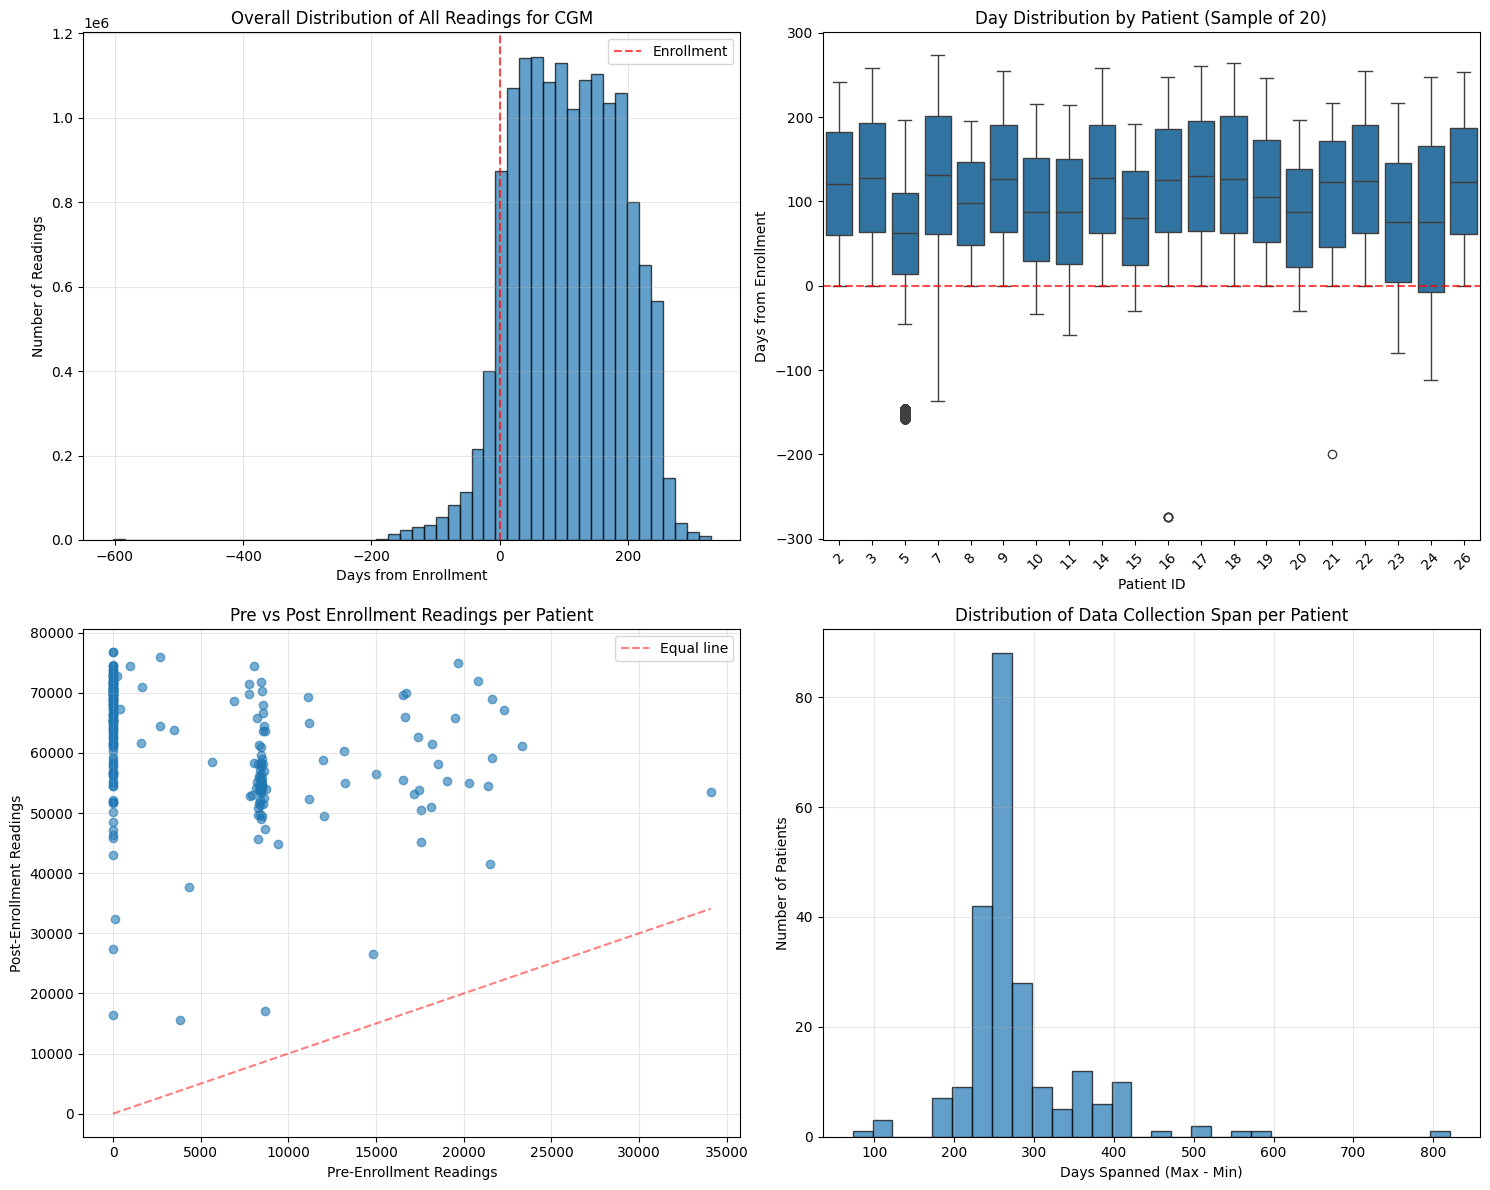

In [49]:
plot_data_distribution(cgm_df, "CGM")

2025-10-25T19:05:20 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-25T19:05:20 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_58361/79258776.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pre_post_counts = df.groupby('PtID').apply(


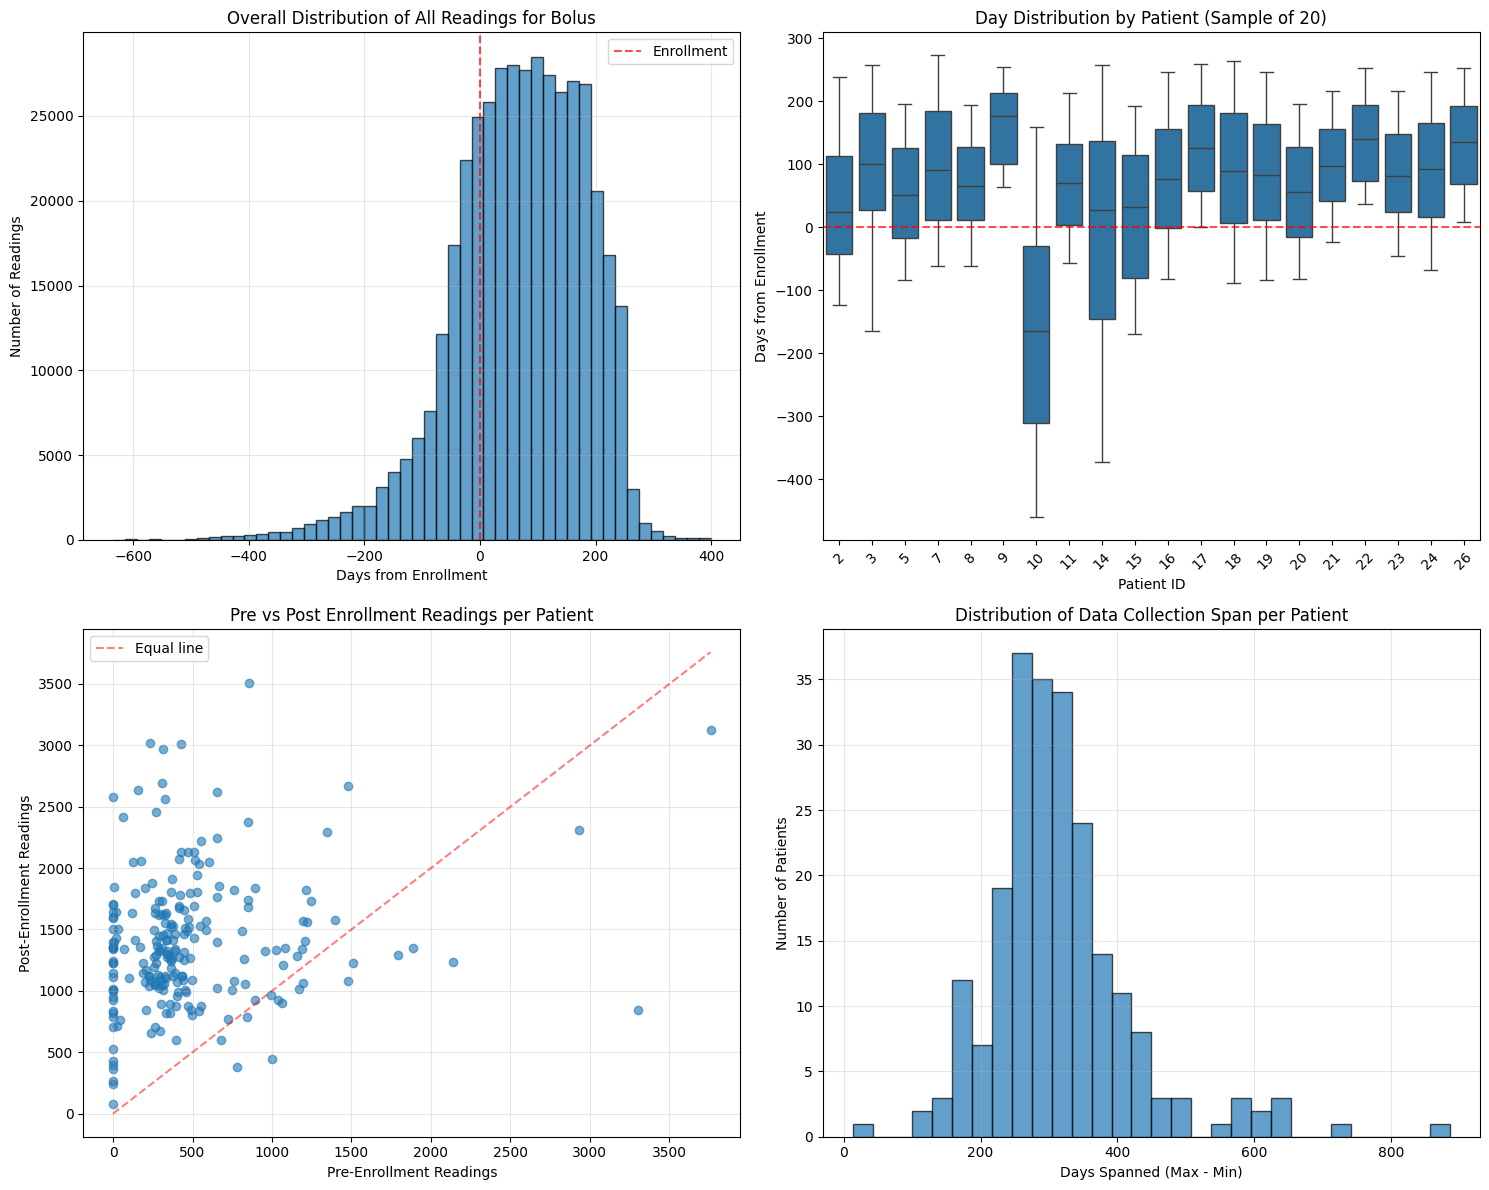

In [50]:
plot_data_distribution(bolus_df, "Bolus")

2025-10-25T19:05:24 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-25T19:05:24 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_58361/79258776.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pre_post_counts = df.groupby('PtID').apply(


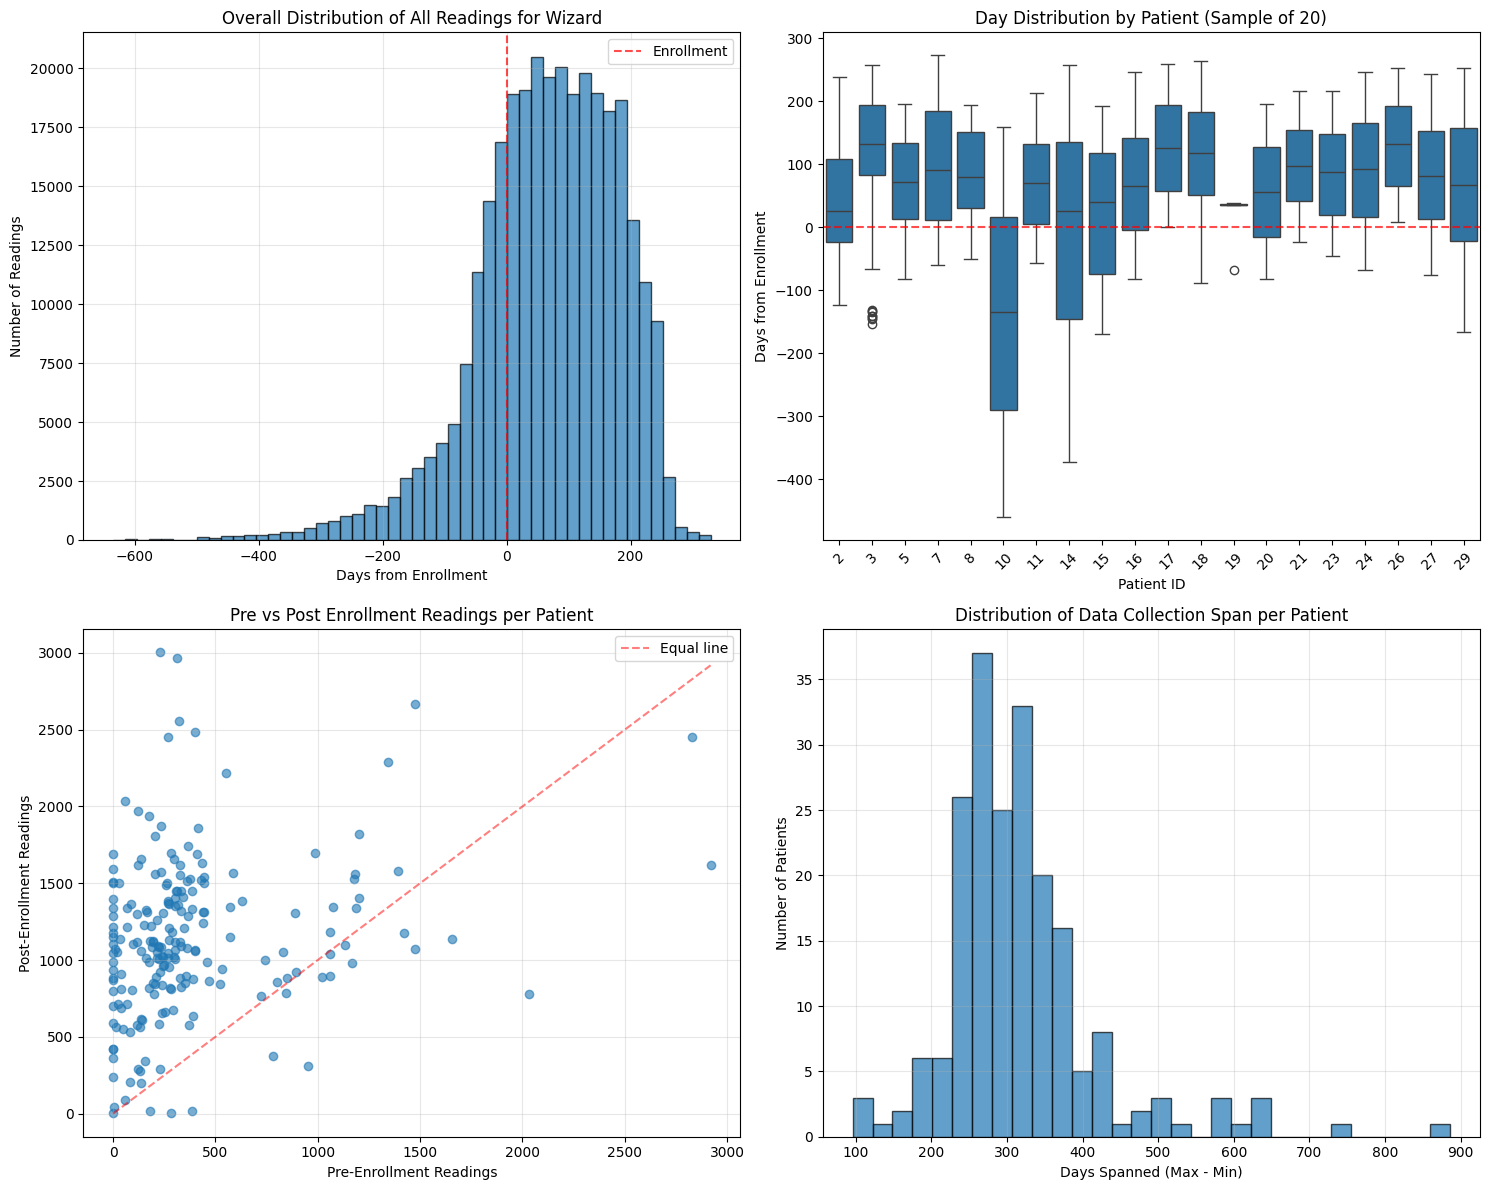

In [51]:
plot_data_distribution(wizard_df, "Wizard")

2025-10-25T19:05:30 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-25T19:05:30 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/lv/s2fdnq713td8c15d7dlzjk6c0000gn/T/ipykernel_58361/79258776.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pre_post_counts = df.groupby('PtID').apply(


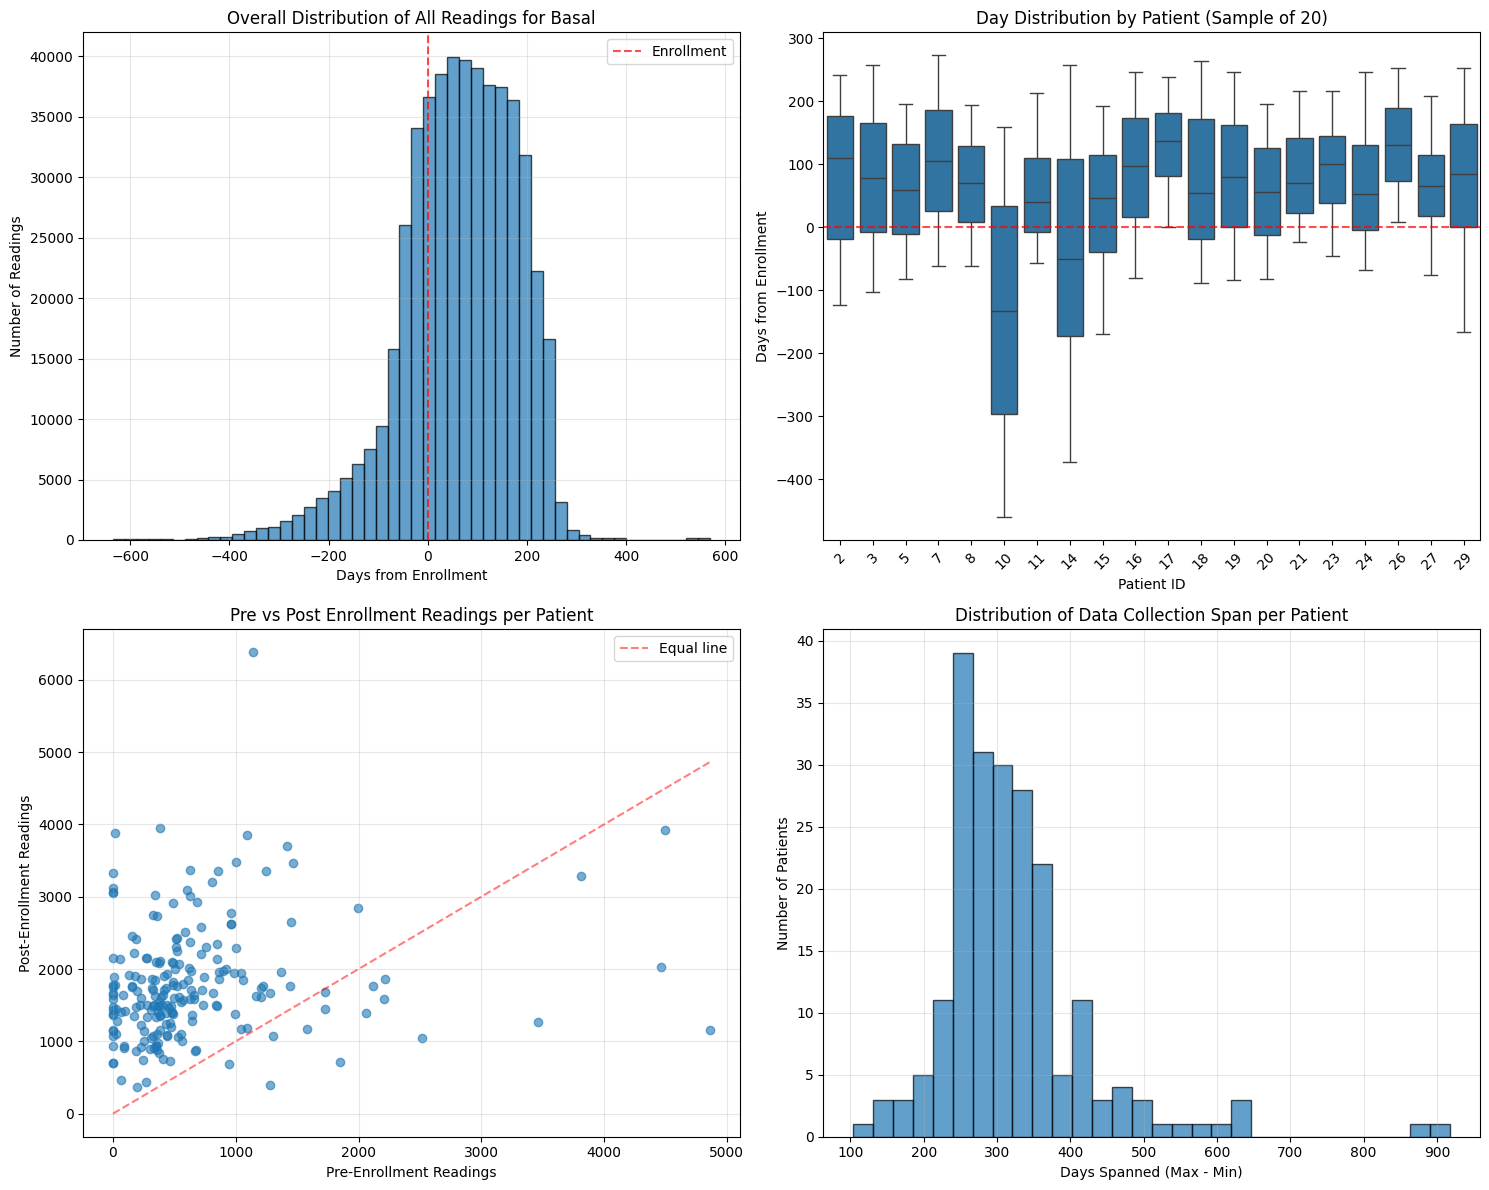

In [52]:
plot_data_distribution(basal_df, "Basal")